In [175]:
pip install numpy split-folders scikit-image keras scikit-learn matplotlib pickle tensorflow

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install tensorflow~=2.10.0

     |████████████████████████████████| 241.2 MB 29.2 MB/s eta 0:00:01    |█████████████████▏              | 129.6 MB 148 kB/s eta 0:12:35
     |████████████████████████████████| 42 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 5.9 MB 56.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 44.4 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 63.8 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow
    Found exis

In [247]:
import numpy as np
import os
import splitfolders
from skimage.io import imread
import random
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pickle import dump, load
import keras
import tensorflow as tf
import time
import csv
import re
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

## Import dataset

In [2]:
# Get path to dataset in local computer
cwd = os.path.join(os.getcwd(), "Crochet_Stitches_Dataset_100")
cwd

'/Users/stephanieyolanda/Documents/Study/Y3S2/CM3070 Final Project/Implementation (Final)/Crochet_Stitches_Dataset_100'

In [372]:
# Get the labels from the folder names in dataset

classes = []
for file in os.scandir(cwd):
    if not file.name.startswith('.'):
        classes.append(file.name)
classes

['SC', 'DC', 'HDC']

### Import images and labels
#### Original dataset

In [566]:
def import_dataset(ds_pkl_path, dataset_path, classes=classes, img_size=(224,224)):
    
    if os.path.isfile(ds_pkl_path) == False:

        images, labels = [], []

        for c in classes:
            label = classes.index(c)
            for file in os.scandir(os.path.join(dataset_path, c)):
                if not file.name.startswith('.'):
                    image = load_img(file.path, target_size=img_size)
                    image = img_to_array(image)
                    images.append(image)
                    labels.append(label)

        ds = {'images': images, 
              'labels': labels}
        dump(ds, open(ds_pkl_path, 'wb'))

    else:
        ds = load(open(ds_pkl_path, 'rb'))
        images, labels = ds['images'], ds['labels']
        
    return images, labels

In [540]:
images, labels = import_dataset('original_ds.pkl', cwd)

#### Display imported images with labels

In [387]:
# Adapted from https://www.tensorflow.org/tutorials/images/data_augmentation

def display_dataset(images, labels):
    plt.figure(figsize=(10,10))

    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        index = random.randint(0, len(images)-1)
        plt.imshow(images[index].astype(np.uint8))
        plt.title(labels[index])
        plt.axis('off')

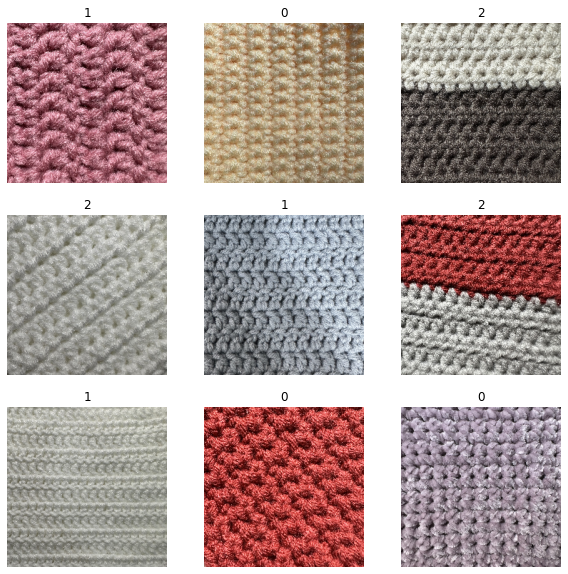

In [388]:
display_dataset(images, labels)

## Data pre-processing
### Reshape dataset

In [77]:
# # Convert to numpy
# X = np.array(images)
# # Convert images to grayscale
# # X = rgb2gray(X)
# # Reshape image from grayscale colorspace to rgb colorspace
# # X = np.expand_dims(X, axis=3)
# # X = X.repeat(3, axis=-1)
# # Normalize images
# X = X.astype('float32')/255

# # Convert to numpy
# y = np.array(labels)
# # Vectorize labels
# y = to_categorical(y)

# print('X:', X.shape)
# print('y:', y.shape)

In [412]:
def data_to_numpy(images, labels):
    # Convert data to numpy array
    X = np.array(images)
    y = np.array(labels)
    
    return X, y

In [453]:
def X_to_grayscale(X):
    # Convert images to grayscale
    X = rgb2gray(np.copy(X))

    # Reshape image from grayscale colorspace to rgb colorspace
    X = np.expand_dims(X, axis=3)
#     print(X_gs[0][0][0], '\n')
    X = X.repeat(3, axis=-1)
#     print(X[0][0][0], '\n')
    return X

In [433]:
def preprocess_data(X, y):   

    # Label vectorization
    y = to_categorical(y)

    # Data normalization
    print('Data normalization:\n')
    
    X_baseline = np.copy(X)/255
    print('Baseline', X_baseline[0][0][0])
    X_xception = xception_preprocess(np.copy(X))
    print('Xception', X_xception[0][0][0])
    X_vgg16 = vgg16_preprocess(np.copy(X))
    print('VGG16   ', X_vgg16[0][0][0])
    X_resnet50 = resnet50_preprocess(np.copy(X))
    print('ResNet50', X_resnet50[0][0][0])

    return X_baseline, X_xception, X_vgg16, X_resnet50, y

In [473]:
X, y = data_to_numpy(images, labels)

In [474]:
X_baseline, X_xception, X_vgg16, X_resnet50, y = preprocess_data(X, y)

Data normalization:

Baseline [0.5058824  0.5058824  0.45882353]
Xception [ 0.01176476  0.01176476 -0.08235294]
VGG16    [13.060997  12.221001   5.3199997]
ResNet50 [13.060997  12.221001   5.3199997]


In [475]:
X_gs = X_to_grayscale(X)
X_baseline_gs, X_xception_gs, X_vgg16_gs, X_resnet50_gs, _ = preprocess_data(X_gs, y)

Data normalization:

Baseline [0.5024894 0.5024894 0.5024894]
Xception [0.00497878 0.00497878 0.00497878]
VGG16    [24.195793 11.355797  4.454796]
ResNet50 [24.195793 11.355797  4.454796]


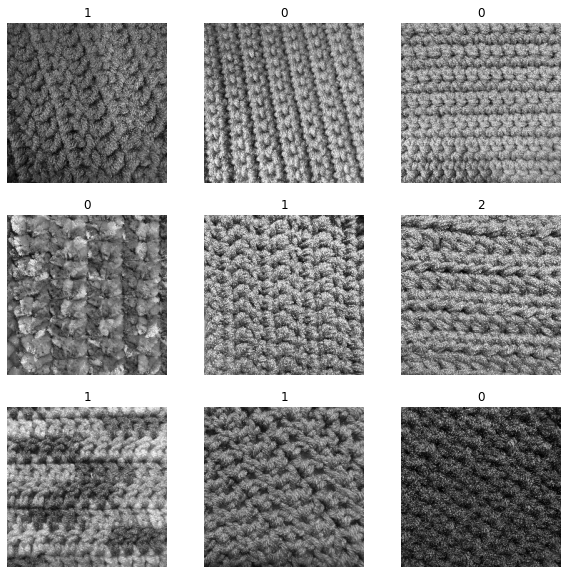

In [476]:
display_dataset(X_gs, labels)

### Split dataset

In [477]:
def split_dataset(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=1, 
                                                        stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.4, 
                                                      shuffle=True, 
                                                      random_state=1, 
                                                      stratify=y_train)
    
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    print('X_val  :', X_val.shape)
    print('y_val  :', y_val.shape)
    print('X_test :', X_test.shape)
    print('y_test :', y_test.shape)
    
    dataset = {'X_train' : X_train,
               'X_test': X_test,
               'X_val': X_val,
               'y_train': y_train,
               'y_test': y_test,
               'y_val': y_val}
    
    return dataset

In [500]:
print('Baseline:')
ds_baseline = split_dataset(X_baseline, y)
print('\nXception:')
ds_xception = split_dataset(X_xception, y)
print('\nVGG16:')
ds_vgg16 = split_dataset(X_vgg16, y)
print('\nResNet50:')
ds_resnet50 = split_dataset(X_resnet50, y)

Baseline:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

Xception:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

VGG16:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

ResNet50:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)


In [479]:
print('Baseline (Grayscale):')
ds_baseline_gs = split_dataset(X_baseline_gs, y)
print('\nXception (Grayscale):')
ds_xception_gs = split_dataset(X_xception_gs, y)
print('\nVGG16 (Grayscale):')
ds_vgg16_gs = split_dataset(X_vgg16_gs, y)
print('\nResNet50 (Grayscale):')
ds_resnet50_gs = split_dataset(X_resnet50_gs, y)

Baseline (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

Xception (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

VGG16 (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

ResNet50 (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)


### Online data augmentation

In [817]:
def augment_data(dataset, batch_size):

    train_gen = ImageDataGenerator(zoom_range=[0.6,1.2],
                                   rotation_range=40,
                                   shear_range=10,
                                   brightness_range=[0.5, 1.1],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='reflect')
#                               preprocessing_function=tf.keras.applications.xception.preprocess_input

# val_gen = ImageDataGenerator()

    train_aug = train_gen.flow(dataset['X_train'], dataset['y_train'], batch_size=batch_size)

    return train_aug

# val_aug = val_gen.flow(ds_baseline['X_val'], ds_baseline['y_val'], batch_size=16)



# val_gen = ImageDataGenerator()
# val_aug = train_gen.flow(X_val, y_val, batch_size=16)

In [481]:
# data_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)
# train_aug = data_aug.flow(X_train, y_train, batch_size=16)
# val_aug = data_aug.flow(X_val, y_val, batch_size=16)

### Offline data augmentation

In [ ]:
train_gen = augment_data(dataset, 1)

images = []
for c in classes:
    aug_path = os.path.join('train_augmented', str(c))
    count=0
    for file in os.scandir(os.path.join(split_cwd, 'train', c)):
        count+=1
        print(count)
        if not file.name.startswith('.'):
            image = imread(file.path)
            image = np.expand_dims(image, axis=0)
        
            i = 0
            for batch in train_gen.flow(image, batch_size=1, save_to_dir=aug_path, save_prefix=str(c), save_format='jpeg'):
                i += 1
                if i>5:
                    break
    print("TOTAL COUNT:", count)

In [600]:
images_aug, labels_aug = import_dataset('train_off_aug_ds.pkl', os.path.join(os.getcwd(), 'train_augmented'))
print('Number of images in each class:')
print('0:',labels_aug.count(0))
print('1:',labels_aug.count(1))
print('2:',labels_aug.count(2))

X_train_aug, y_train_aug = data_to_numpy(images_aug, labels_aug)
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=0)

Number of images in each class:
0: 406
1: 406
2: 406


In [602]:
X_train_baseline_aug, X_train_xception_aug, X_train_vgg16_aug, X_train_resnet50_aug, y_train_aug = preprocess_data(X_train_aug, y_train_aug)

Data normalization:

Baseline [0.38039216 0.3764706  0.35686275]
Xception [-0.23921567 -0.24705881 -0.2862745 ]
VGG16    [-12.939003 -20.779    -26.68    ]
ResNet50 [-12.939003 -20.779    -26.68    ]


In [604]:
X_train_gs_aug = X_to_grayscale(X_train_aug)
X_train_baseline_gs_aug, X_train_xception_gs_aug, X_train_vgg16_gs_aug, X_train_resnet50_gs_aug, _ = preprocess_data(X_train_gs_aug, y_train_aug)

Data normalization:

Baseline [0.37589023 0.37589023 0.37589023]
Xception [-0.24821955 -0.24821955 -0.24821955]
VGG16    [ -8.086998 -20.926994 -27.827995]
ResNet50 [ -8.086998 -20.926994 -27.827995]


In [608]:
# Combine augmented train set with unaugmented train set

# Original (Color)
X_train_baseline_aug = np.concatenate((np.copy(X_train_baseline_aug), np.copy(ds_baseline['X_train'])))
X_train_xception_aug = np.concatenate((np.copy(X_train_xception_aug), np.copy(ds_xception['X_train'])))
X_train_vgg16_aug = np.concatenate((np.copy(X_train_vgg16_aug), np.copy(ds_vgg16['X_train'])))
X_train_resnet50_aug = np.concatenate((np.copy(X_train_resnet50_aug), np.copy(ds_resnet50['X_train'])))

# Grayscale
X_train_baseline_gs_aug = np.concatenate((np.copy(X_train_baseline_gs_aug), np.copy(ds_baseline_gs['X_train'])))
X_train_xception_gs_aug = np.concatenate((np.copy(X_train_xception_gs_aug), np.copy(ds_xception_gs['X_train'])))
X_train_vgg16_gs_aug = np.concatenate((np.copy(X_train_vgg16_gs_aug), np.copy(ds_vgg16_gs['X_train'])))
X_train_resnet50_gs_aug = np.concatenate((np.copy(X_train_resnet50_gs_aug), np.copy(ds_resnet50_gs['X_train'])))

y_train_aug = np.concatenate((np.copy(y_train_aug), np.copy(ds_baseline['y_train'])))

In [609]:
# Copy dictionary format of other datasets (storing all sets and labels)

# Original (Color)
ds_baseline_aug = ds_baseline.copy()
ds_xception_aug = ds_xception.copy()
ds_vgg16_aug = ds_vgg16.copy()
ds_resnet50_aug = ds_resnet50.copy()

# Grayscale
ds_baseline_gs_aug = ds_baseline_gs.copy()
ds_xception_gs_aug = ds_xception_gs.copy()
ds_vgg16_gs_aug = ds_vgg16_gs.copy()
ds_resnet50_gs_aug = ds_resnet50_gs.copy()

In [610]:
# Update X_train and y_train

# Original (Color)
ds_baseline_aug['X_train'], ds_baseline_aug['y_train'] = shuffle(X_train_baseline_aug, y_train_aug, random_state=0)
ds_xception_aug['X_train'], ds_xception_aug['y_train'] = shuffle(X_train_xception_aug, y_train_aug, random_state=0)
ds_vgg16_aug['X_train'], ds_vgg16_aug['y_train'] = shuffle(X_train_vgg16_aug, y_train_aug, random_state=0)
ds_resnet50_aug['X_train'], ds_resnet50_aug['y_train'] = shuffle(X_train_resnet50_aug, y_train_aug, random_state=0)

# Grayscale
ds_baseline_gs_aug['X_train'], ds_baseline_gs_aug['y_train'] = shuffle(X_train_baseline_gs_aug, y_train_aug, random_state=0)
ds_xception_gs_aug['X_train'], ds_xception_gs_aug['y_train'] = shuffle(X_train_xception_gs_aug, y_train_aug, random_state=0)
ds_vgg16_gs_aug['X_train'], ds_vgg16_gs_aug['y_train'] = shuffle(X_train_vgg16_gs_aug, y_train_aug, random_state=0)
ds_resnet50_gs_aug['X_train'], ds_resnet50_gs_aug['y_train'] = shuffle(X_train_resnet50_gs_aug, y_train_aug, random_state=0)

## Build models for classification

### Initialize variables

In [767]:
INPUT_DIMENSION = ds_baseline['X_train'].shape[1:4]
OUTPUT_DIMENSION = ds_baseline['y_train'].shape[1]
# LEARNING_RATE = 0.001
# OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
OPTIMIZER = 'Adam'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = [CategoricalAccuracy(name='accuracy'), 
           Precision(name='precision'), 
           Recall(name='recall'),
           AUC(name='auc', multi_label=True)]
BATCH_SIZE = 16
EPOCHS = 20
MONITOR = 'val_loss'

LAYERS = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

In [627]:
# Original dataset
if os.path.isfile('datasets/og_ds.pkl') == False:  
    og_ds = {'Baseline':ds_baseline,
                'Xception':ds_xception,
                'VGG16':ds_vgg16,
                'ResNet50':ds_resnet50}
    dump(og_ds, open('datasets/og_ds.pkl', 'wb'))
else:
    og_ds = load(open('datasets/og_ds.pkl', 'rb'))

# Original grayscale dataset
if os.path.isfile('datasets/og_gs_ds.pkl') == False:  
    og_gs_ds = {'Baseline':ds_baseline_gs,
                'Xception':ds_xception_gs,
                'VGG16':ds_vgg16_gs,
                'ResNet50':ds_resnet50_gs}
    dump(og_gs_ds, open('datasets/og_gs_ds.pkl', 'wb'))
else:
    og_gs_ds = load(open('datasets/og_gs_ds.pkl', 'rb'))

# Online augmented dataset
on_aug_ds = {'Baseline':augment_data(ds_baseline, BATCH_SIZE),
             'Xception':augment_data(ds_xception, BATCH_SIZE),
             'VGG16':augment_data(ds_vgg16, BATCH_SIZE),
             'ResNet50':augment_data(ds_resnet50, BATCH_SIZE)}

# Online augmented grayscale dataset
on_aug_gs_ds = {'Baseline':augment_data(ds_baseline_gs, BATCH_SIZE),
                'Xception':augment_data(ds_xception_gs, BATCH_SIZE),
                'VGG16':augment_data(ds_vgg16_gs, BATCH_SIZE),
                'ResNet50':augment_data(ds_resnet50, BATCH_SIZE)}

# Offline augmented dataset
if os.path.isfile('datasets/off_aug_ds.pkl') == False:  
    off_aug_ds = {'Baseline':ds_baseline_aug,
                  'Xception':ds_xception_aug,
                  'VGG16':ds_vgg16_aug,
                  'ResNet50':ds_resnet50_aug}
    dump(off_aug_ds, open('datasets/off_aug_ds.pkl', 'wb'))
else:
    off_aug_ds = load(open('datasets/off_aug_ds.pkl', 'rb'))

# Offline augmented grayscale dataset
if os.path.isfile('datasets/off_aug_gs_ds.pkl') == False:  
    off_aug_gs_ds = {'Baseline':ds_baseline_gs_aug,
                     'Xception':ds_xception_gs_aug,
                     'VGG16':ds_vgg16_gs_aug,
                     'ResNet50':ds_resnet50_gs_aug}
    dump(off_aug_gs_ds, open('datasets/off_aug_gs_ds.pkl', 'wb'))
else:
    off_aug_gs_ds = load(open('datasets/off_aug_gs_ds.pkl', 'rb'))

In [811]:
def choose_dataset(model_name, grayscale, aug_type, batch_size=BATCH_SIZE):
    
    if model_name == 'baseline_model':
        key = 'Baseline'
    elif model_name == 'xception_model':
        key = 'Xception'
    elif model_name == 'vgg16_model':
        key = 'VGG16'
    elif model_name == 'resnet50_model':
        key = 'ResNet50'
        
    print(aug_type)
    
    if grayscale == False:
        
        if aug_type == 'None':
            
            # Original dataset
            if os.path.isfile('datasets/og_ds.pkl') == False:  
                og_ds = {'Baseline':ds_baseline,
                            'Xception':ds_xception,
                            'VGG16':ds_vgg16,
                            'ResNet50':ds_resnet50}
                dump(og_ds, open('datasets/og_ds.pkl', 'wb'))
            else:
                og_ds = load(open('datasets/og_ds.pkl', 'rb'))
                
            dataset = og_ds[key]
            dataset_str = 'og_ds' + '/' + key
            
        elif aug_type == 'Online':
            
            # Original dataset
            if os.path.isfile('datasets/og_ds.pkl') == False:  
                og_ds = {'Baseline':ds_baseline,
                            'Xception':ds_xception,
                            'VGG16':ds_vgg16,
                            'ResNet50':ds_resnet50}
                dump(og_ds, open('datasets/og_ds.pkl', 'wb'))
            else:
                og_ds = load(open('datasets/og_ds.pkl', 'rb'))
                
            # Online augmented dataset
            on_aug_ds = {'Baseline':augment_data(ds_baseline, BATCH_SIZE),
                         'Xception':augment_data(ds_xception, BATCH_SIZE),
                         'VGG16':augment_data(ds_vgg16, BATCH_SIZE),
                         'ResNet50':augment_data(ds_resnet50, BATCH_SIZE)}
            
            dataset = [on_aug_ds[key],og_ds[key]]
            dataset_str = 'on_aug_ds' + '/' + key
            
        elif aug_type == 'Offline':
            
            dataset = off_aug_ds[key]
            dataset_str = 'off_aug_ds' + '/' + key
            
    elif grayscale == True:
        
        if aug_type == 'None':
            
            # Original grayscale dataset
            if os.path.isfile('datasets/og_gs_ds.pkl') == False:  
                og_gs_ds = {'Baseline':ds_baseline_gs,
                            'Xception':ds_xception_gs,
                            'VGG16':ds_vgg16_gs,
                            'ResNet50':ds_resnet50_gs}
                dump(og_gs_ds, open('datasets/og_gs_ds.pkl', 'wb'))
            else:
                og_gs_ds = load(open('datasets/og_gs_ds.pkl', 'rb'))
                
            dataset = og_gs_ds[key]
            dataset_str = 'og_gs_ds' + '/' + key
            
        elif aug_type == 'Online':
            
             # Original grayscale dataset
            if os.path.isfile('datasets/og_gs_ds.pkl') == False:  
                og_gs_ds = {'Baseline':ds_baseline_gs,
                            'Xception':ds_xception_gs,
                            'VGG16':ds_vgg16_gs,
                            'ResNet50':ds_resnet50_gs}
                dump(og_gs_ds, open('datasets/og_gs_ds.pkl', 'wb'))
            else:
                og_gs_ds = load(open('datasets/og_gs_ds.pkl', 'rb'))
                
            # Online augmented grayscale dataset
            on_aug_gs_ds = {'Baseline':augment_data(ds_baseline_gs, BATCH_SIZE),
                            'Xception':augment_data(ds_xception_gs, BATCH_SIZE),
                            'VGG16':augment_data(ds_vgg16_gs, BATCH_SIZE),
                            'ResNet50':augment_data(ds_resnet50, BATCH_SIZE)}
            
            dataset = [on_aug_gs_ds[key],og_gs_ds[key]]
            dataset_str = 'on_aug_gs_ds' + '/' + key
            
        elif aug_type == 'Offline':
            
            # Offline augmented grayscale dataset
            if os.path.isfile('datasets/off_aug_gs_ds.pkl') == False:  
                off_aug_gs_ds = {'Baseline':ds_baseline_gs_aug,
                                 'Xception':ds_xception_gs_aug,
                                 'VGG16':ds_vgg16_gs_aug,
                                 'ResNet50':ds_resnet50_gs_aug}
                dump(off_aug_gs_ds, open('datasets/off_aug_gs_ds.pkl', 'wb'))
            else:
                off_aug_gs_ds = load(open('datasets/off_aug_gs_ds.pkl', 'rb'))
                
            dataset = off_aug_gs_ds[key]
            dataset_str = 'off_aug_gs_ds' + '/' + key
            
    return dataset, dataset_str

In [769]:
def get_dataset_string(dataset):
    
    string = str()
    
#     if augmented == 'No':
    if np.array_equal(dataset, ds_baseline):
        string = 'ds_baseline'
    elif np.array_equal(dataset, ds_baseline_gs):
        string = 'ds_baseline_gs'
    elif np.array_equal(dataset, ds_xception):
        string = 'ds_xception'
    elif np.array_equal(dataset, ds_xception_gs):
        string = 'ds_xception_gs'
    elif np.array_equal(dataset, ds_vgg16):
        string = 'ds_vgg16'
    elif np.array_equal(dataset, ds_vgg16_gs):
        string = 'ds_vgg16_gs'
    elif np.array_equal(dataset, ds_resnet50):
        string = 'ds_resnet50'
    elif np.array_equal(dataset, ds_resnet50_gs):
        string = 'ds_resnet50_gs'
    
#     elif augmented == 'Online':
#         string = string+'_online_aug'
#         string = 'train_aug'
#         if np.array_equal(dataset, augment_data(ds_baseline)):
#             string = 'train_aug_baseline'
#         elif np.array_equal(dataset, augment_data(ds_baseline_gs)):
#             string = 'train_aug_baseline_gs'
#         elif np.array_equal(dataset, augment_data(ds_xception)):
#             string = 'train_aug_xception'
#         elif np.array_equal(dataset, augment_data(ds_xception_gs)):
#             string = 'train_aug_xception_gs'
#         elif np.array_equal(dataset, augment_data(ds_vgg16)):
#             string = 'train_aug_vgg16'
#         elif np.array_equal(dataset, augment_data(ds_vgg16_gs)):
#             string = 'train_aug_vgg16_gs'
#         elif np.array_equal(dataset, augment_data(ds_resnet50)):
#             string = 'train_aug_resnet50'
#         elif np.array_equal(dataset, augment_data(ds_resnet50_gs)):
#             string = 'train_aug_resnet50_gs'
    return string

In [770]:
def get_model_params(dataset_str, grayscale, aug_type, layers=LAYERS,
                     input_dimension=INPUT_DIMENSION,
                     output_dimension=OUTPUT_DIMENSION,
                     optimizer=OPTIMIZER,
                     loss_function=LOSS_FUNC,
                     learning_rate=LEARNING_RATE,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS):
    
    model_params = {'Dataset':str(dataset_str),
                    'Augmentation':str(aug_type),
                    'Grayscale':bool(grayscale),
                    'Num_Layers':layers['num_layers'],
                    'Dense_Layers':str(layers['dense']),
                    'Dropout_Layers':str(layers['dropout']),
                    'Input_Dimension':str(input_dimension), 
                    'Output_Dimension':int(output_dimension),
#                     'Optimizer': re.search(pattern, str(optimizer)).group(1).split('.')[-1],
                    'Optimizer':str(optimizer),
                    'Loss_Function':str(loss_function),
                    'Learning_Rate':float(learning_rate),
                    'Batch_Size':int(batch_size),
                    'Epochs':int(epochs)}
    
    return model_params

### Functions for saving parameters and results to csv

In [771]:
# data can be model_params or metrics
def export_to_csv(paths, data, csv_filename):

    data = paths | data

#     csv_path = os.path.join(os.getcwd(), csv_filename)
#     csv_path = 'models/'+csv_filename

    # Write to new csv if file not exist
    if not os.path.isfile(csv_filename):
        with open(csv_filename, 'w') as f:
            w = csv.DictWriter(f, fieldnames=list(data.keys()))
            w.writeheader()
            w.writerow(data)
            f.close()
    # Append to existing csv
    else:
        with open(csv_filename, 'a', newline='') as f:
            w = csv.DictWriter(f, fieldnames=list(data.keys()))
            w.writerow(data)
            f.close()

### Functions for Model Building and Training

In [772]:
# layers: dict containing lists of number of layers, dense, and dropout parameters (length of list = num_layers)

def build_model(pretrained_model, 
                model_name, 
                layers=LAYERS, 
                output_dimension=OUTPUT_DIMENSION,
                optimizer=OPTIMIZER, 
                loss_func=LOSS_FUNC, 
                metrics=METRICS):
    
#     OPTIMIZER = Adam(learning_rate=LEARNING_RATE)

    if layers["num_layers"] == len(layers["dense"]) and (layers["num_layers"] == len(layers["dropout"]) or layers["num_layers"] == len(layers["dropout"])-1):
        
        first_dropout = False
        
        # Build on pre-trained model
        x = pretrained_model.output
        x = GlobalAveragePooling2D()(x)
        
        # Either add or don't add drop out layer before the dense layers
        if layers["num_layers"] == len(layers["dropout"])-1:
            x = Dropout(layers["dropout"][0])(x)
            first_dropout = True
        
        # Add dense layers
        for layer in range(layers["num_layers"]):
            x = Dense(layers["dense"][layer], activation='relu')(x)
            if first_dropout == True:
                x = Dropout(layers["dropout"][layer+1])(x)
            else:
                x = Dropout(layers["dropout"][layer])(x)

        model_outputs = Dense(output_dimension, activation='softmax')(x)
        model = Model(pretrained_model.input, model_outputs)

        model._name = model_name 
        model.compile(optimizer=optimizer, 
                      loss=loss_func, 
                      metrics=metrics)
        return model
    
    else:
        print("Number of dense/dropout parameters do not match number of layers")

In [773]:
# https://saturncloud.io/blog/how-to-use-pandas-to-check-if-a-row-exists-with-certain-values/

def check_model_exist(model_name, model_params, model_params_path='model_params.csv'):
    
    model_exist = False
    paths = None
    
#     csv_path = os.path.join(os.getcwd(), model_params_path)
    
    if os.path.isfile(model_params_path):
        df = pd.read_csv(model_params_path)
        
        df_exist = df[(df['Model_Path'].str.contains(str(model_name))) &
                      (df['History_Path'].str.contains(str(model_name))) &
                        (df['Dataset']==str(model_params['Dataset'])) &
                        (df['Num_Layers']==int(model_params['Num_Layers'])) &
                        (df['Dense_Layers']==str(model_params['Dense_Layers'])) &
                        (df['Dropout_Layers']==str(model_params['Dropout_Layers'])) &
                        (df['Input_Dimension']==str(model_params['Input_Dimension'])) &
                        (df['Output_Dimension']==int(model_params['Output_Dimension'])) &
                        (df['Optimizer']==str(model_params['Optimizer'])) &
                        (df['Loss_Function']==str(model_params['Loss_Function'])) &
                        (df['Learning_Rate']==float(model_params['Learning_Rate'])) &
                        (df['Batch_Size']==int(model_params['Batch_Size'])) &
                        (df['Epochs']==int(model_params['Epochs'])) &
                        (df['Augmentation']==str(model_params['Augmentation'])) &
                        (df['Grayscale']==bool(model_params['Grayscale']))]


        if not df_exist.empty:
            model_exist = True
            paths = {'Model_Path':df_exist['Model_Path'].values[0],
                     'History_Path':df_exist['History_Path'].values[0]}

    return model_exist, paths

In [774]:
def check_metrics_exist(model_paths, model_metrics_path='model_metrics.csv'):
    
#     csv_path = os.path.join(os.getcwd(), model_params_path)
    metrics_exist = False
    
    if os.path.isfile(model_metrics_path):
        df = pd.read_csv(model_metrics_path)
        
        df_exist = df[(df['Model_Path']==str(model_paths['Model_Path'])) &
                      (df['History_Path']==str(model_paths['History_Path']))]

        if not df_exist.empty:
            metrics_exist = True

    return metrics_exist

In [775]:
def get_model_paths(model_name):
    timestamp = str(int(time.time()))
    model_path = "models/"+model_name+"_"+timestamp+".keras"
    history_path = "models/trained_"+model_name+"_"+timestamp+".pkl"
    
    paths = {'Model_Path':model_path,
             'History_Path':history_path}
    return paths

In [805]:
# def train_model(model_name, layers, model,
#                 dataset=None, 
#                 on_aug_datagen=None, 
#                 off_aug_dataset=None,
#                 aug_type='None',
#                 overwrite=False):

def train_model(model_name, model, model_params, dataset,
                layers=LAYERS,        
                overwrite=False,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS):
    

    model_exist, model_paths = check_model_exist(model_name, model_params)
    print(model_params)
    print(model_paths)
    print(model_exist)
    
    aug_type=model_params['Augmentation']
    
    if model_exist == False or overwrite == True:
        
        model_paths = get_model_paths(model_name)

        model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']

        if aug_type == 'Online':
            datagen, dataset = dataset[0], dataset[1]
            trained_model = model.fit(datagen,
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      validation_data=(dataset['X_val'], dataset['y_val']),
                                      verbose=1)
        else:
            trained_model = model.fit(dataset['X_train'], dataset['y_train'],
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      validation_data=(dataset['X_val'], dataset['y_val']),
                                      verbose=1)

        # Save model locally
        save_model(model, model_path)

        # Save model history
        dump(trained_model, open(history_path, 'wb'))
        
        export_to_csv(model_paths, model_params, 'model_params.csv')

    else:
        model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']
        model = load_model(model_path)
        trained_model = load(open(history_path, 'rb'))
        
    return model, trained_model, model_paths

### Functions for Model Evaluation

In [777]:
def plot_history(trained_model, metric_func):
    metric = trained_model.history[metric_func]
    val_metric_func = 'val_' + metric_func
    val_metric = trained_model.history[val_metric_func]
    epochs = range(1, len(metric) + 1)
    
    
    plt.clf()
    plt.title('Training and validation ' + str(metric_func))
    plt.plot(epochs, metric, label='Training '+ str(metric_func))
    plt.plot(epochs, val_metric, label='Validation '+ str(metric_func)) 
    plt.ylabel(str(metric_func).capitalize())
    plt.legend()
    plt.show()

In [778]:
def get_results(model, X_test, y_test, model_paths, metrics_exist=False, labels=classes):
        
    preds = model.predict(X_test)
    
    # Calculate evaluation metrics scores
    accuracy = accuracy_score(y_test.argmax(axis=1), 
                              preds.argmax(axis=1))
    precision = precision_score(y_test.argmax(axis=1), 
                                preds.argmax(axis=1),
                                average='macro')
    recall = recall_score(y_test.argmax(axis=1), 
                          preds.argmax(axis=1),
                          average='macro')
    roc_auc = roc_auc_score(y_test, 
                            preds,
                            multi_class='ovo',
                            average='macro')

    # Print scores
    print('Score results from predicting the test set:')
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('AUC: {:.2f}'.format(roc_auc))
    
    cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    metrics = {'Accuracy':accuracy,
               'Precision':precision,
               'Recall':recall,
               'ROC_AUC':roc_auc}
    
    # Export if metrics does not exist in csv file
    if metrics_exist == False:
        export_to_csv(model_paths, metrics, 'model_metrics.csv')

### Baseline Model

INFO:tensorflow:Assets written to: ram://42bc6f9c-ce69-4298-88c0-5eda5ee08bad/assets


INFO:tensorflow:Assets written to: ram://42bc6f9c-ce69-4298-88c0-5eda5ee08bad/assets


Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_74 (Flatten)        (None, 150528)            0         
                                                                 
 dense_106 (Dense)           (None, 3)                 451587    
                                                                 
Total params: 451,587
Trainable params: 451,587
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 6ms/step - loss: 9.0208 - accuracy: 0.3333 - precision: 0.3263 - recall: 0.3229 - auc: 0.5531


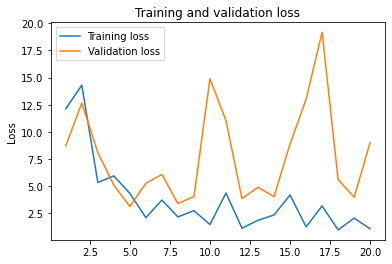

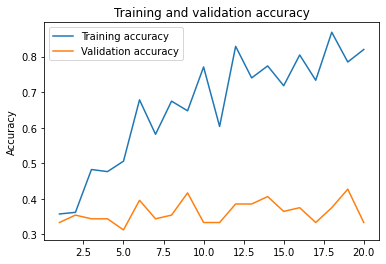

2/2 [==============================] - 0s 12ms/step
Score results from predicting the test set:
Accuracy: 0.38
Precision: 0.49
Recall: 0.38
AUC: 0.57


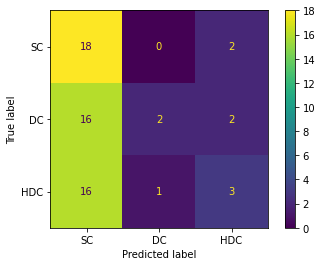

In [731]:
model_name = 'baseline_model'
aug_type = 'Offline'
grayscale = True
# dataset = ds_baseline
# datagen = augment_data(dataset, BATCH_SIZE)

dataset, dataset_str = choose_dataset(model_name, grayscale, aug_type, batch_size=BATCH_SIZE)

# dataset_str = get_dataset_string(dataset)

model_params = get_model_params(dataset_str, grayscale, aug_type)

model_exist, model_paths = check_model_exist(model_name, model_params)

if model_exist==False:
    model_paths = get_model_paths(model_name)

model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']

baseline_model = Sequential()
baseline_model.add(Flatten())
baseline_model.add(Dense(OUTPUT_DIMENSION, activation='softmax'))
baseline_model._name = model_name
baseline_model.compile(optimizer=OPTIMIZER, 
                    loss=LOSS_FUNC, 
                    metrics=METRICS)

if model_exist==False:
    
    if aug_type=='Online':
        datagen, dataset = dataset[0], dataset[1]
        trained_baseline_model = baseline_model.fit(datagen,
                                                    batch_size=BATCH_SIZE, 
                                                    epochs=EPOCHS, 
                                                    validation_data=(dataset['X_val'], dataset['y_val']),
                                                    verbose=0)
    else:
        trained_baseline_model = baseline_model.fit(dataset['X_train'], dataset['y_train'],
                                                batch_size=BATCH_SIZE, 
                                                epochs=EPOCHS, 
                                                validation_data=(dataset['X_val'], dataset['y_val']),
                                                verbose=0)
 
    # Save model locally
    save_model(baseline_model, model_path)
    
    # Save model history
    dump(trained_baseline_model, open(history_path, 'wb'))
    
    export_to_csv(model_paths, model_params, 'model_params.csv')
    
else:
    baseline_model = load_model(model_path)
    trained_baseline_model = load(open(history_path, 'rb'))

metrics_exist = check_metrics_exist(model_paths)
metrics = get_results(baseline_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          metrics_exist=metrics_exist)

In [734]:
baseline_model.summary() 

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_74 (Flatten)        (None, 150528)            0         
                                                                 
 dense_106 (Dense)           (None, 3)                 451587    
                                                                 
Total params: 451,587
Trainable params: 451,587
Non-trainable params: 0
_________________________________________________________________


In [735]:
baseline_val_score = baseline_model.evaluate(dataset['X_val'], 
                                             dataset['y_val'])

3/3 [==============================] - 0s 10ms/step - loss: 9.0208 - accuracy: 0.3333 - precision: 0.3263 - recall: 0.3229 - auc: 0.5531


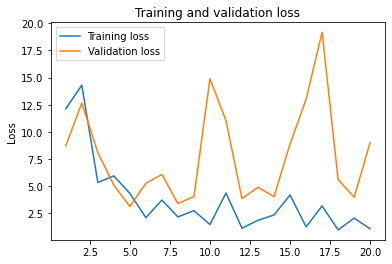

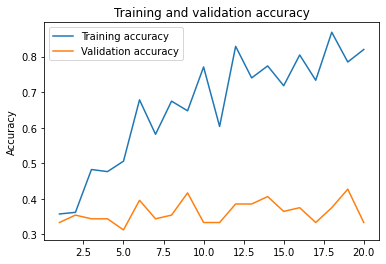

In [732]:
plot_history(trained_baseline_model, 'loss')
plot_history(trained_baseline_model, 'accuracy')

2/2 [==============================] - 0s 8ms/step
Score results from predicting the test set:
Accuracy: 0.38
Precision: 0.49
Recall: 0.38
AUC: 0.57


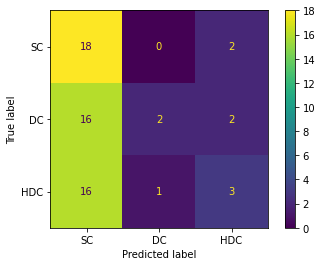

In [738]:
metrics_exist = check_metrics_exist(model_paths)

metrics = get_results(baseline_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          metrics_exist=metrics_exist)

### Xception

In [763]:
LAYERS = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

DS_OPT = {"grayscale":False,
            "aug_type":'None'}

In [802]:
def xception_model(model_name='xception_model',
                   ds_opt = DS_OPT,
                   layers=LAYERS, 
                   output_dimension=OUTPUT_DIMENSION, 
                   input_dimension=INPUT_DIMENSION, 
                   learning_rate = LEARNING_RATE,
                   optimizer=OPTIMIZER, 
                   loss_func=LOSS_FUNC, 
                   metrics=METRICS,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS):

    
    # Pre-trained model
    xception = Xception(include_top=False,
                        weights='imagenet',
                        classes=output_dimension,
                        input_shape=input_dimension)

    xception.trainable=False

    xception_model = build_model(xception, 
                                 model_name, 
                                 layers=layers,
                                 output_dimension=output_dimension,
                                 optimizer=optimizer, 
                                 loss_func=loss_func, 
                                 metrics=metrics)
    
    dataset, dataset_str = choose_dataset(model_name, ds_opt['grayscale'], ds_opt['aug_type'], batch_size=batch_size)

    model_params = get_model_params(dataset_str, ds_opt['grayscale'], ds_opt['aug_type'], 
                                    layers=layers,
                                    input_dimension=input_dimension,
                                    output_dimension=output_dimension,
                                    optimizer=optimizer,
                                    loss_function=loss_func,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    epochs=epochs)

    xception_model, trained_xception_model, model_paths = train_model(model_name, 
                                                                      xception_model,
                                                                      model_params,
                                                                      dataset,
                                                                      layers=layers, 
                                                                      overwrite=False)
    
    if ds_opt['aug_type'] == 'Online':
        dataset = dataset[1]

    metrics_exist = check_metrics_exist(model_paths)
    metrics = get_results(xception_model, 
              dataset['X_test'], 
              dataset['y_test'],
              model_paths,
              metrics_exist=metrics_exist)

In [350]:
xception_model.summary()

Model: "xception_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                    

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_67 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_66[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_67[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_70 (A

In [351]:
xception_val_score = xception_model.evaluate(dataset['X_val'], dataset['y_val'])

3/3 [==============================] - 8s 2s/step - loss: 0.8346 - accuracy: 0.6146 - precision: 0.6667 - recall: 0.4167 - auc: 0.7996


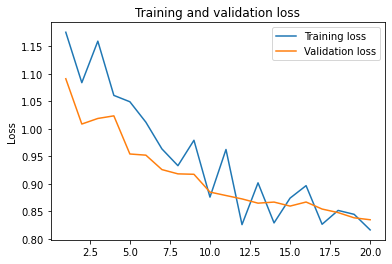

In [352]:
plot_history(trained_xception_model, 'loss')

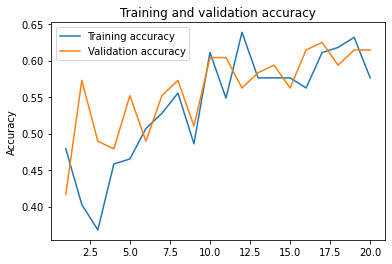

In [353]:
plot_history(trained_xception_model, 'accuracy')

2/2 [==============================] - 5s 2s/step
Score results from predicting the test set:
Accuracy: 0.55
Precision: 0.55
Recall: 0.55
AUC: 0.74


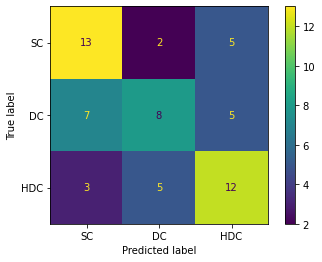

In [354]:
metrics_exist = check_metrics_exist(model_paths)

metrics = get_results(xception_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          metrics_exist=metrics_exist)

### VGG16

In [355]:
model_name = 'vgg16_model'
dataset = ds_vgg16_gs
datagen = augment_data(dataset, batch_size=BATCH_SIZE)

# Pre-trained model
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              classes=OUTPUT_DIMENSION,
              input_shape=INPUT_DIMENSION)

vgg16.trainable = False

params = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

vgg16_model = build_model(vgg16, model_name, params)

# vgg16_model, trained_vgg16_model = train_model(model_name, params, vgg16_model, train_aug, overwrite=False)
vgg16_model, trained_vgg16_model, model_paths = train_model(model_name, 
                                                            params, 
                                                            vgg16_model, 
                                                            dataset=dataset, 
                                                            datagen=datagen,
                                                            overwrite=False)

Epoch 1/20
9/9 [==============================] - 41s 5s/step - loss: 3.7052 - accuracy: 0.4375 - precision: 0.4271 - recall: 0.3542 - auc: 0.5536 - val_loss: 2.7967 - val_accuracy: 0.2396 - val_precision: 0.2366 - val_recall: 0.2292 - val_auc: 0.4032
Epoch 2/20
9/9 [==============================] - 38s 4s/step - loss: 3.6232 - accuracy: 0.2986 - precision: 0.3094 - recall: 0.2986 - auc: 0.4810 - val_loss: 2.5514 - val_accuracy: 0.2708 - val_precision: 0.2584 - val_recall: 0.2396 - val_auc: 0.4187
Epoch 3/20
9/9 [==============================] - 40s 5s/step - loss: 3.6617 - accuracy: 0.3403 - precision: 0.3380 - recall: 0.3333 - auc: 0.4983 - val_loss: 2.2312 - val_accuracy: 0.2917 - val_precision: 0.2706 - val_recall: 0.2396 - val_auc: 0.4298
Epoch 4/20
9/9 [==============================] - 38s 4s/step - loss: 3.4542 - accuracy: 0.3333 - precision: 0.3357 - recall: 0.3264 - auc: 0.4539 - val_loss: 2.1255 - val_accuracy: 0.2917 - val_precision: 0.3000 - val_recall: 0.2812 - val_auc:

INFO:tensorflow:Assets written to: ram://491d7e34-50dc-45d0-ad4a-691dfe8f48a3/assets


INFO:tensorflow:Assets written to: ram://491d7e34-50dc-45d0-ad4a-691dfe8f48a3/assets


In [809]:
def vgg16_model(model_name='vgg16_model',
                ds_opt = DS_OPT,
                layers=LAYERS, 
                output_dimension=OUTPUT_DIMENSION, 
                input_dimension=INPUT_DIMENSION, 
                learning_rate = LEARNING_RATE,
                optimizer=OPTIMIZER, 
                loss_func=LOSS_FUNC, 
                metrics=METRICS,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS):

    
    # Pre-trained model
    vgg16 = VGG16(include_top=False,
                  weights='imagenet',
                  classes=output_dimension,
                  input_shape=input_dimension)

    vgg16.trainable=False

    vgg16_model = build_model(vgg16, 
                              model_name, 
                              layers=layers,
                              output_dimension=output_dimension,
                              optimizer=optimizer, 
                              loss_func=loss_func, 
                              metrics=metrics)
    
    dataset, dataset_str = choose_dataset(model_name, ds_opt['grayscale'], ds_opt['aug_type'], batch_size=batch_size)

    model_params = get_model_params(dataset_str, ds_opt['grayscale'], ds_opt['aug_type'], 
                                    layers=layers,
                                    input_dimension=input_dimension,
                                    output_dimension=output_dimension,
                                    optimizer=optimizer,
                                    loss_function=loss_func,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    epochs=epochs)

    vgg16_model, trained_vgg16_model, model_paths = train_model(model_name, 
                                                                vgg16_model,
                                                                model_params,
                                                                dataset,
                                                                layers=layers, 
                                                                overwrite=False)

    if ds_opt['aug_type'] == 'Online':
        dataset = dataset[1]
        
    metrics_exist = check_metrics_exist(model_paths)
    metrics = get_results(vgg16_model, 
              dataset['X_test'], 
              dataset['y_test'],
              model_paths,
              metrics_exist=metrics_exist)

In [356]:
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [357]:
vgg16_val_score = vgg16_model.evaluate(dataset['X_val'], dataset['y_val'])

3/3 [==============================] - 14s 5s/step - loss: 1.1083 - accuracy: 0.4792 - precision: 0.4865 - recall: 0.3750 - auc: 0.6971


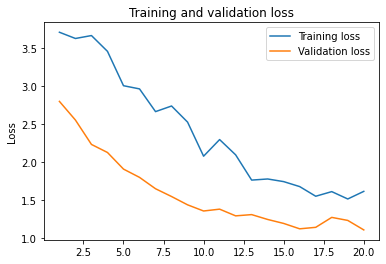

In [358]:
plot_history(trained_vgg16_model, 'loss')

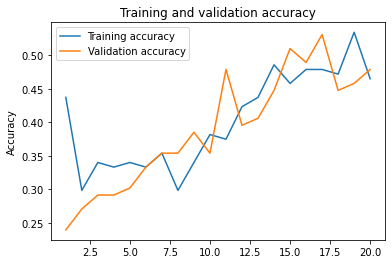

In [359]:
plot_history(trained_vgg16_model, 'accuracy')

2/2 [==============================] - 9s 4s/step
Score results from predicting the test set:
Accuracy: 0.55
Precision: 0.55
Recall: 0.55
AUC: 0.76


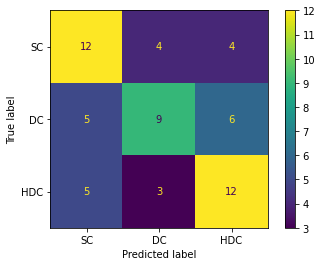

In [360]:
metrics_exist = check_metrics_exist(model_paths)

metrics = get_results(vgg16_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          metrics_exist=metrics_exist)

### ResNet50

In [361]:
model_name = 'resnet50_model'
dataset = ds_resnet50_gs
datagen = augment_data(dataset, BATCH_SIZE)

# Pre-trained model
resnet50 = ResNet50(include_top=False,
              weights='imagenet',
              classes=OUTPUT_DIMENSION,
              input_shape=INPUT_DIMENSION)

resnet50.trainable = False

params = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

resnet50_model = build_model(resnet50, model_name, params)

# vgg16_model, trained_vgg16_model = train_model(model_name, params, vgg16_model, train_aug, overwrite=False)
resnet50_model, trained_resnet50_model, model_paths = train_model(model_name, 
                                                                  params, 
                                                                  resnet50_model, 
                                                                  dataset=dataset, 
                                                                  datagen=datagen,
                                                                  overwrite=False)

Epoch 1/20
9/9 [==============================] - 26s 2s/step - loss: 1.8274 - accuracy: 0.3750 - precision: 0.3756 - recall: 0.3208 - auc: 0.5608 - val_loss: 1.0699 - val_accuracy: 0.4062 - val_precision: 0.5152 - val_recall: 0.3542 - val_auc: 0.6705
Epoch 2/20
9/9 [==============================] - 19s 2s/step - loss: 1.4929 - accuracy: 0.3958 - precision: 0.3738 - recall: 0.2778 - auc: 0.5584 - val_loss: 0.9679 - val_accuracy: 0.4688 - val_precision: 0.6207 - val_recall: 0.3750 - val_auc: 0.7328
Epoch 3/20
9/9 [==============================] - 20s 2s/step - loss: 1.4525 - accuracy: 0.3611 - precision: 0.4000 - recall: 0.3333 - auc: 0.5600 - val_loss: 0.9145 - val_accuracy: 0.5833 - val_precision: 0.6316 - val_recall: 0.3750 - val_auc: 0.7684
Epoch 4/20
9/9 [==============================] - 20s 2s/step - loss: 1.0988 - accuracy: 0.5486 - precision: 0.5447 - recall: 0.4653 - auc: 0.7044 - val_loss: 0.8640 - val_accuracy: 0.6146 - val_precision: 0.6620 - val_recall: 0.4896 - val_auc:

INFO:tensorflow:Assets written to: ram://c8a7cd0f-a927-4b12-ab7e-7ab8da313fcb/assets


INFO:tensorflow:Assets written to: ram://c8a7cd0f-a927-4b12-ab7e-7ab8da313fcb/assets


In [807]:
def resnet50_model(model_name='resnet50_model',
                   ds_opt = DS_OPT,
                   layers=LAYERS, 
                   output_dimension=OUTPUT_DIMENSION, 
                   input_dimension=INPUT_DIMENSION, 
                   learning_rate = LEARNING_RATE,
                   optimizer=OPTIMIZER, 
                   loss_func=LOSS_FUNC, 
                   metrics=METRICS,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS):

    
    # Pre-trained model
    resnet50 = ResNet50(include_top=False,
                        weights='imagenet',
                        classes=output_dimension,
                        input_shape=input_dimension)

    resnet50.trainable=False

    resnet50_model = build_model(resnet50, 
                                 model_name, 
                                 layers=layers,
                                 output_dimension=output_dimension,
                                 optimizer=optimizer, 
                                 loss_func=loss_func, 
                                 metrics=metrics)
    
    dataset, dataset_str = choose_dataset(model_name, ds_opt['grayscale'], ds_opt['aug_type'], batch_size=batch_size)

    model_params = get_model_params(dataset_str, ds_opt['grayscale'], ds_opt['aug_type'], 
                                    layers=LAYERS,
                                    input_dimension=input_dimension,
                                    output_dimension=output_dimension,
                                    optimizer=optimizer,
                                    loss_function=loss_func,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    epochs=epochs)

    resnet50_model, trained_resnet50_model, model_paths = train_model(model_name, 
                                                                     resnet50_model,
                                                                     model_params,
                                                                     dataset,
                                                                     layers=layers, 
                                                                     overwrite=False)
    if ds_opt['aug_type'] == 'Online':
        dataset = dataset[1]

    metrics_exist = check_metrics_exist(model_paths)
    metrics = get_results(resnet50_model, 
              dataset['X_test'], 
              dataset['y_test'],
              model_paths,
              metrics_exist=metrics_exist)

In [362]:
resnet50_val_score = resnet50_model.evaluate(dataset['X_val'], dataset['y_val'])

3/3 [==============================] - 10s 3s/step - loss: 0.7246 - accuracy: 0.7083 - precision: 0.7303 - recall: 0.6771 - auc: 0.8662


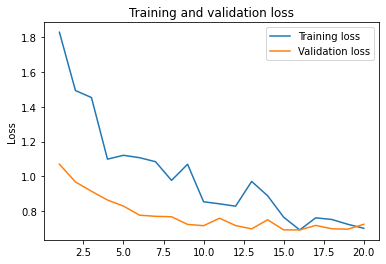

In [363]:
plot_history(trained_resnet50_model, 'loss')

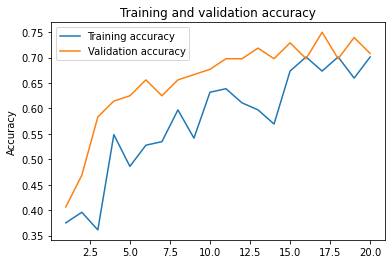

In [364]:
plot_history(trained_resnet50_model, 'accuracy')

2/2 [==============================] - 7s 3s/step
Score results from predicting the test set:
Accuracy: 0.63
Precision: 0.63
Recall: 0.63
AUC: 0.82


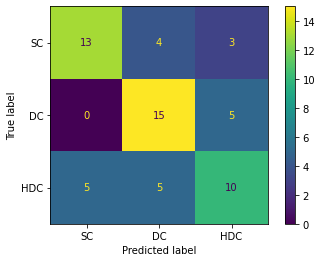

In [365]:
metrics_exist = check_metrics_exist(model_paths)

metrics = get_results(resnet50_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          metrics_exist=metrics_exist)

### Choosing the best dataset option

ResNet-50
 {'grayscale': False, 'aug_type': 'None'}
None
{'Dataset': 'og_ds/ResNet50', 'Augmentation': 'None', 'Grayscale': False, 'Num_Layers': 0, 'Dense_Layers': '[]', 'Dropout_Layers': '[0.5]', 'Input_Dimension': '(224, 224, 3)', 'Output_Dimension': 3, 'Optimizer': 'Adam', 'Loss_Function': 'categorical_crossentropy', 'Learning_Rate': 0.001, 'Batch_Size': 16, 'Epochs': 20}
{'Model_Path': 'models/resnet50_model_1692903659.keras', 'History_Path': 'models/trained_resnet50_model_1692903659.pkl'}
True
2/2 [==============================] - 5s 2s/step
Score results from predicting the test set:
Accuracy: 0.58
Precision: 0.60
Recall: 0.58
AUC: 0.79


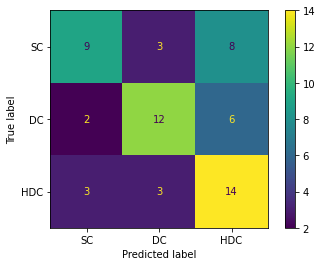

ResNet-50
 {'grayscale': True, 'aug_type': 'Offline'}
Offline
{'Dataset': 'off_aug_gs_ds/ResNet50', 'Augmentation': 'Offline', 'Grayscale': True, 'Num_Layers': 0, 'Dense_Layers': '[]', 'Dropout_Layers': '[0.5]', 'Input_Dimension': '(224, 224, 3)', 'Output_Dimension': 3, 'Optimizer': 'Adam', 'Loss_Function': 'categorical_crossentropy', 'Learning_Rate': 0.001, 'Batch_Size': 16, 'Epochs': 20}
None
False
Epoch 1/20
86/86 [==============================] - 114s 1s/step - loss: 1.5039 - accuracy: 0.4671 - precision: 0.4796 - recall: 0.4266 - auc: 0.6440 - val_loss: 0.7011 - val_accuracy: 0.7292 - val_precision: 0.7848 - val_recall: 0.6458 - val_auc: 0.8894
Epoch 2/20
86/86 [==============================] - 126s 1s/step - loss: 1.0206 - accuracy: 0.5580 - precision: 0.5772 - recall: 0.5103 - auc: 0.7460 - val_loss: 0.5401 - val_accuracy: 0.8021 - val_precision: 0.8659 - val_recall: 0.7396 - val_auc: 0.9277
Epoch 3/20
86/86 [==============================] - 127s 1s/step - loss: 0.8302 - accu

INFO:tensorflow:Assets written to: ram://65684852-0ad6-4652-8a2c-945b09e0e7c9/assets


INFO:tensorflow:Assets written to: ram://65684852-0ad6-4652-8a2c-945b09e0e7c9/assets


2/2 [==============================] - 6s 2s/step
Score results from predicting the test set:
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
AUC: 0.96


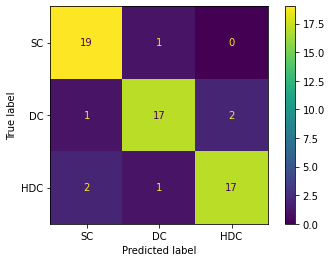

In [816]:
ds_opts = [{"grayscale":False,
            "aug_type":'None'},
#            {"grayscale":False,
#             "aug_type":'Online'},
#            {"grayscale":False,
#             "aug_type":'Offline'},
#            {"grayscale":True,
#             "aug_type":'None'},
#            {"grayscale":True,
#             "aug_type":'Online'},
           {"grayscale":True,
            "aug_type":'Offline'}]

for ds_opt in ds_opts:
    
#     print("Xception\n", ds_opt)
#     xception_model(model_name='xception_model',
#                    ds_opt=ds_opt,
#                    layers=LAYERS, 
#                    output_dimension=OUTPUT_DIMENSION, 
#                    input_dimension=INPUT_DIMENSION, 
#                    learning_ratbe = LEARNING_RATE,
#                    optimizer=OPTIMIZER, 
#                    loss_func=LOSS_FUNC, 
#                    metrics=METRICS,
#                    batch_size=BATCH_SIZE,
#                    epochs=EPOCHS)
    
#     print("VGG-16\n", ds_opt)
#     vgg16_model(model_name='vgg16_model',
#                 ds_opt = ds_opt,
#                 layers=LAYERS, 
#                 output_dimension=OUTPUT_DIMENSION, 
#                 input_dimension=INPUT_DIMENSION, 
#                 learning_rate = LEARNING_RATE,
#                 optimizer=OPTIMIZER, 
#                 loss_func=LOSS_FUNC, 
#                 metrics=METRICS,
#                 batch_size=BATCH_SIZE,
#                 epochs=EPOCHS)
    
    print("ResNet-50\n", ds_opt)
    resnet50_model(model_name='resnet50_model',
                   ds_opt = ds_opt,
                   layers=LAYERS, 
                   output_dimension=OUTPUT_DIMENSION, 
                   input_dimension=INPUT_DIMENSION, 
                   learning_rate = LEARNING_RATE,
                   optimizer=OPTIMIZER, 
                   loss_func=LOSS_FUNC, 
                   metrics=METRICS,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS)